# Setup stuff

In [5]:
%matplotlib inline

In [6]:
import skip_phrase
from skip_phrase.dataset_readers.reader import *
from skip_phrase.models.skip_phrase import *
from skip_phrase.predictors.predictor import *

In [7]:
from allennlp.models.archival import load_archive
from allennlp.service.predictors import Predictor

In [8]:
import sys
sys.executable

'/home/ubuntu/anaconda3/envs/umt/bin/python'

In [9]:
from scipy import spatial

In [10]:
archive = load_archive('models/europarl_full/model.tar.gz')

In [11]:
def cos_sim(p1, p2):
    return 1 - spatial.distance.cosine(p1, p2)

In [52]:
def pred_cos_sim(s1, s2):
    p1 = predictor.predict_json(predictor.load_line(s1))['pivot_phrase_embedding']
    p2 = predictor.predict_json(predictor.load_line(s2))['pivot_phrase_embedding']
    return cos_sim(p1, p2)

In [12]:
??Predictor.from_archive

Signature: Predictor.from_archive(archive:allennlp.models.archival.Archive, predictor_name:str) -> 'Predictor'
Source:   
    @classmethod
    def from_archive(cls, archive: Archive, predictor_name: str) -> 'Predictor':
        """
        Instantiate a :class:`Predictor` from an :class:`~allennlp.models.archival.Archive`;
        that is, from the result of training a model. Optionally specify which `Predictor`
        subclass; otherwise, the default one for the model will be used.
        """
        config = archive.config

        dataset_reader_params = config["dataset_reader"]
        dataset_reader = DatasetReader.from_params(dataset_reader_params)

        model = archive.model
        model.eval()

        return Predictor.by_name(predictor_name)(model, dataset_reader)
File:      ~/research/skip_phrase/allennlp/service/predictors/predictor.py
Type:      method


In [13]:
predictor = Predictor.from_archive(archive, 'skip_phrase_predictor')

In [14]:
p1 = predictor.predict_json(predictor.load_line("good"))['pivot_phrase_embedding']

In [15]:
p2 = predictor.predict_json(predictor.load_line("aweasome"))['pivot_phrase_embedding']

In [16]:
cos_sim(p1, p2)

0.003710966373554836

In [17]:
words = open('models/europarl_vocab/words.txt', 'r')

In [18]:
words = words.readlines()

In [19]:
words = [w[:-1] for w in words]

In [20]:
len(words)

52115

In [21]:
all_words = words

# Plot

In [29]:
NUM_WORDS_TO_PLOT = 300

In [30]:
words = all_words[1:NUM_WORDS_TO_PLOT]

(-8.755648, 8.92178)

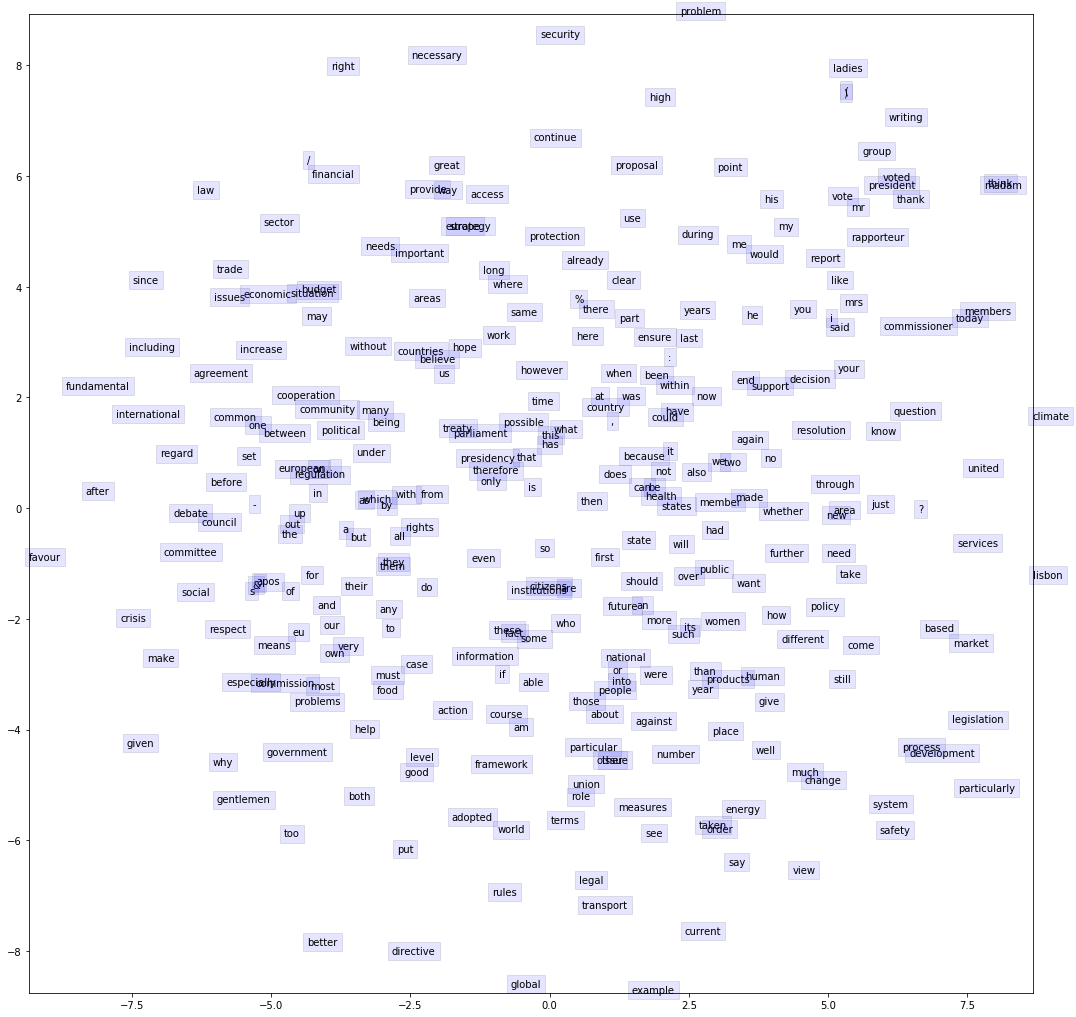

In [31]:
import os
import pickle
import argparse
import matplotlib
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

mt = 'tsne'
if mt == 'pca':
    model = PCA(n_components=2)
elif mt == 'tsne':
    model = TSNE(n_components=2, perplexity=30, init='pca', method='exact', n_iter=5000)
X = [predictor.predict_json(predictor.load_line(word))['pivot_phrase_embedding'] for word in words]
X = model.fit_transform(X)
plt.figure(figsize=(18, 18))
for i in range(len(X)):
    plt.text(X[i, 0], X[i, 1], words[i], bbox=dict(facecolor='blue', alpha=0.1))
plt.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
plt.ylim((np.min(X[:, 1]), np.max(X[:, 1])))

# Similarity

In [61]:
s1 = '1'
s2 = '6'
pred_cos_sim(s1, s2)

0.2769474651688639